## TOI 2048

Here's an example of combining multiple sectors from TESS, and some other custom plots.

We'll use TOI 2048 as an example here, as it has 3 sectors of TESS data (observing sectors 16, 23 and 24).<br>
We kind of know there might be a planet at $P_{orb}=13.79$ days and $T_0 = 1739.1133$ days TESS time, so the plan is to detrend each sector with notch, combine them, and look at the transits phased up.

Start with normal importing

In [9]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['lines.linewidth']   = 2
mpl.rcParams['axes.linewidth']    = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.labelsize']   = 10
mpl.rcParams['xtick.labelsize']   = 10
mpl.rcParams['axes.labelsize']    = 10
mpl.rcParams['legend.numpoints']  = 1
mpl.rcParams['axes.labelweight']  = 'semibold'
mpl.rcParams['axes.titlesize']    = 10
mpl.rcParams['axes.titleweight']  = 'semibold'
mpl.rcParams['font.weight']       = 'semibold'
import interface as thymeLN
import lcfunctions as lcfunc
import core

#### Define some target data files, and read them with the interface

these are included in the code repo for example purposed

In [ ]:
target_name = 159873822

dfile1 = 'tessdata/TOI2048/tess2019253231442-s0016-0000000159873822-0152-s_lc.fits'
sect1 = '16'

dfile2 = 'tessdata/TOI2048/tess2020078014623-s0023-0000000159873822-0177-s_lc.fits'
sect2 = '23'

dfile3 = 'tessdata/TOI2048/tess2020106103520-s0024-0000000159873822-0180-s_lc.fits'
sect3 = '24'



targ1 = thymeLN.target(target_name)
targ1.load_data_tess(dfile1,sector_label=sect1)


targ2 = thymeLN.target(target_name)
targ2.load_data_tess(dfile2,sector_label=sect2)

targ3 = thymeLN.target(target_name)
targ3.load_data_tess(dfile3,sector_label=sect3)

#### Run the notch filter on all three sectors 
Takes about 5 mins

In [ ]:
##notch
targ1.run_notch()
targ2.run_notch()
targ3.run_notch()

# THis code will save them as pickle files so you don't have to wait for things in future runs 
# 
# fff = open('toi2048_test_16-23-24.pkl','wb')
# pickle.dump((targ1,targ2,targ3),fff)
# fff.close()
# targ1,targ2,targ3 = pickle.load(open('toi2048_test_16-23-24.pkl','rb'))

#### The target object has a built in function to combine lightcurves, 
it will generate a new copy of everything so the originals are preserved <br>
Note that the sector and reduction information is tracked (slightly janky at the moment but it's there)

In [81]:
## combine the first two sectors (16 and 23)
ctarg0 = targ1.combine_lc(targ2)

display('Notch Windowsizes: ' +str(ctarg0.notch_windowsize))

## combine that with the final sector (24)
ctarg  = ctarg0.combine_lc(targ3)

Combining notch detrends


'Notch Windowsizes: [0.5, 0.5]'

Combining notch detrends


#### Phase up the detrended lightcurves to the expected period of the planet
the core functions that contains all the main code from the notch and locor pipelines has a phase calculator that's easy to use <br>

By default it will put the transit at zero phase (ranging from 0 to 1), but I like it at 0.5 phase for easy plots so I add half the orbital period to the $T_0$ value<br>
Also we'll get indices for the approximate transit centres from nice plotting later

In [82]:
##the phased time
ppp = core.calc_phase(ctarg.data.t,13.79,1739.1133+13.79/2)
##transit centre regions
intr = np.where((ppp > 0.49) & (ppp<0.51))[0]

#### Make some plots!

Plots:
 1. The lightcurve from PDCSAP, with transit regions in red and binned into 10000 points in black
 2. The detrended lightcurve with transit regions in red
 3. The phased lightcurve with the transits at phase=0, and color coded by sector of observation
 

<IPython.core.display.Javascript object>


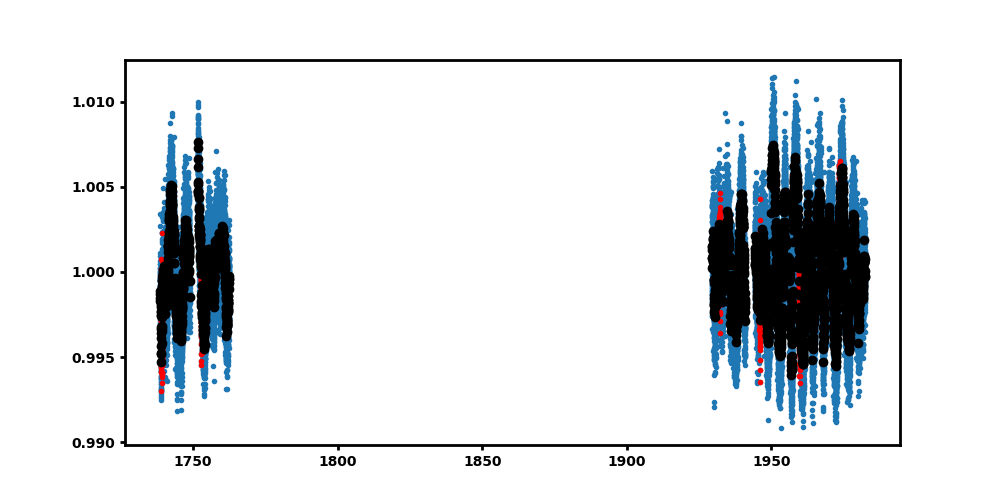

<IPython.core.display.Javascript object>


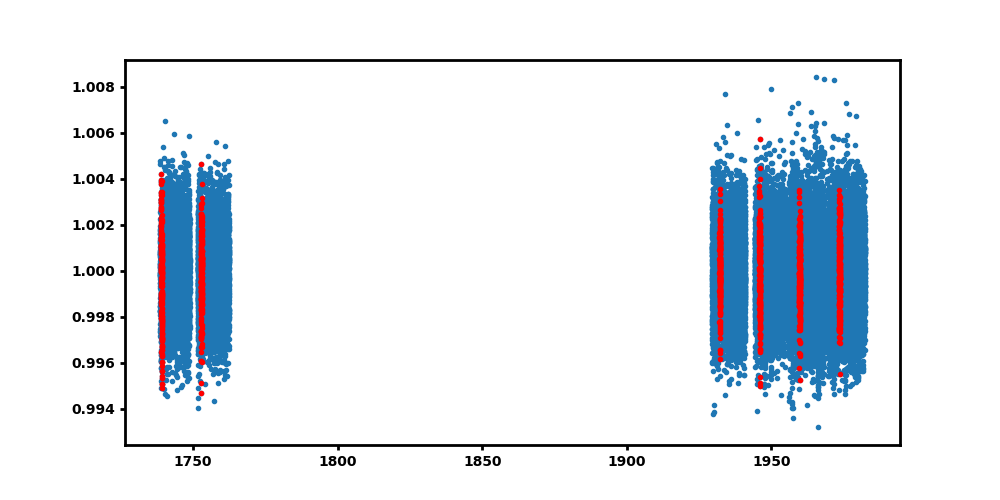

<IPython.core.display.Javascript object>


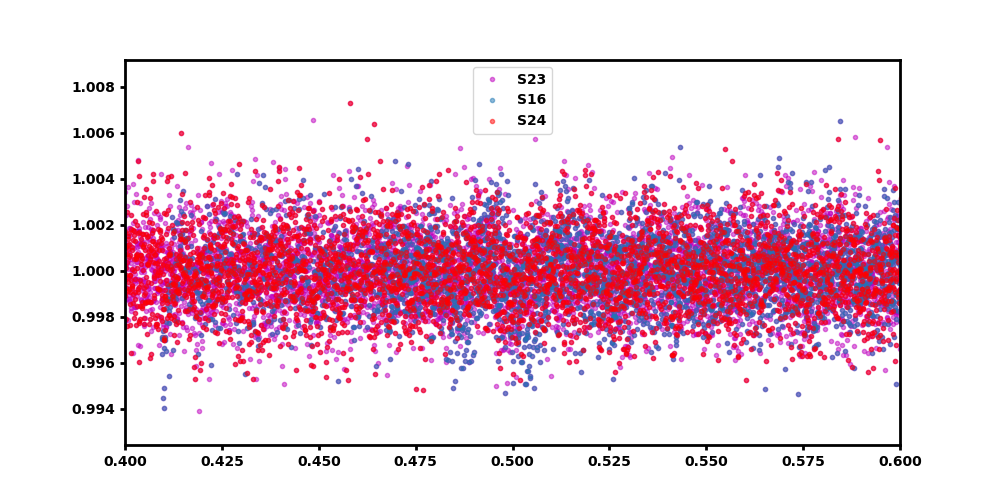

(0.4, 0.6)

In [83]:
%matplotlib notebook
fbin,binsize,ebin,allgoodind,tbin = core.lcbin(ctarg.data.t,ctarg.data.fcor,10000,usemean=False,userobustmean=True)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(ctarg.data.t,ctarg.data.fcor,'.')
ax.plot(ctarg.data.t[intr],ctarg.data.fcor[intr],'.r')
ax.plot(tbin,fbin,'ko')

#ax.plot(ctarg.data.t,ctarg.data.fraw,'.g',alpha=0.3)

fig2,ax2= plt.subplots(figsize=(10,5))
ax2.plot(ctarg.notch.t,ctarg.notch.detrend,'.')
ax2.plot(ctarg.notch.t[intr],ctarg.notch.detrend[intr],'.r')



fig3,ax3 = plt.subplots(figsize=(10,5))
qwe1 = np.where(ctarg.data.t < 1800)[0]
qwe2 = np.where(ctarg.data.t > np.min(targ3.data.t))[0]
ax3.plot(ppp,ctarg.notch.detrend,'.m',alpha=0.5,label='S23')
ax3.plot(ppp[qwe1],ctarg.notch.detrend[qwe1],'.C0',alpha=0.5,label='S16')
ax3.plot(ppp[qwe2],ctarg.notch.detrend[qwe2],'.r',alpha=0.5,label='S24')
ax3.legend()
#fig3.savefig('toi2048_phased.pdf')
ax3.set_xlim([0.4,0.6])



We can see that the transits appear to be where we expect them in the third plot, but the blue transits are deeper than the red/magenta, Zoom in on the transits in sectors 23 and 24 in plot 1 above and convince yourself the depths vary.

#### BIC statistis
Seems like some of the transits are more convincing than others (red)


<IPython.core.display.Javascript object>


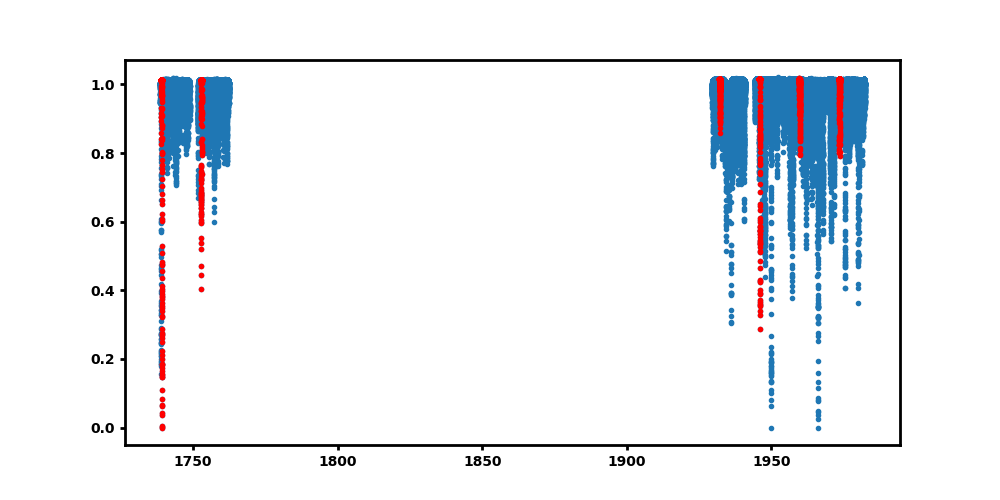

In [89]:
%matplotlib notebook
fig5,ax5=plt.subplots(figsize=(10,5))
ax5.plot(ctarg.notch.t,ctarg.notch.bicstat,'.')
ax5.plot(ctarg.notch.t[intr],ctarg.notch.bicstat[intr],'r.')


In [87]:
ctarg.notch.bicstat


array([0.97890411, 0.94820252, 0.94667475, ..., 0.96435875, 0.94539331,
       0.94811795])

In [90]:
##the phased time
ppp = core.calc_phase(ctarg.data.t,13.79*2,1739.1133+13.79/2)
##transit centre regions
intr = np.where((ppp > 0.49) & (ppp<0.51))[0]

<IPython.core.display.Javascript object>


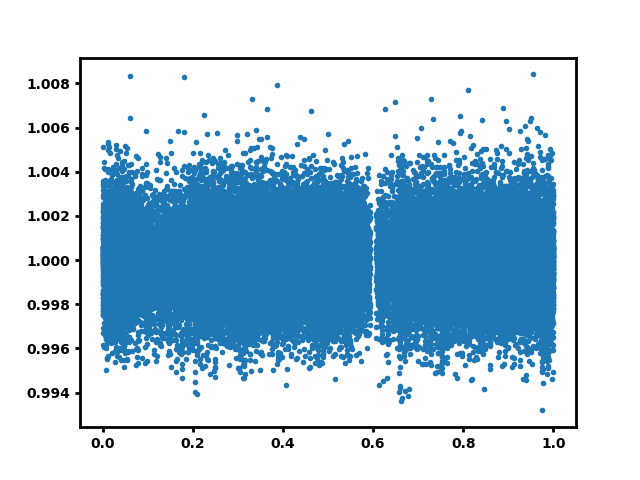

In [92]:
%matplotlib notebook
plt.plot(ppp,ctarg.notch.detrend,'.')
